# Analysis of usage of the term "sygeplejersker" in DR, TV2 and the danish parliament

## Extract content of zip

## Imports

In [2]:
import pandas as pd
import numpy as np
import csv
import re
import time
import tqdm
import zipfile
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
import itertools

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Selenium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

# Scraping
import requests
from bs4 import BeautifulSoup as bs
import os
import lxml
from lxml import objectify
import ftplib
from io import BytesIO

#Text processing
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from PIL import Image
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jgb569\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

> NOTE: The following code must be run on a computer with danish language as google behaves differently based on the computers language settings

#### 1:  Generate search terms

Search terms follow the following format: We search for the month and year in the format DR articles inclue a timestap. Manual Google searches proved to provide relevant research results mostly limited to the month provided. In this way we create a list of links to DR articles. All articles are located on the site https://www.dr.dk/nyheder or a subsite. This can be included in the google search. An example of a search is: jan. 2012" AND "sygeplejersker*" site:https://www.dr.dk/nyheder.

In [3]:
# Generate empty list with search terms
search_terms = []
# Generate combinations of year-month and term search combinations
for year in range(2012, 2023):
    months = ['jan.', 'feb.', 'mar.', 'apr.', 'maj', 'jun.', 'jul.', 'aug.', 'sep.', 'okt.', 'nov.', 'dec.']
    for month in months:
        term = f'"{month} {year}" AND "sygeplejersker*" site:https://www.dr.dk/nyheder/ \n'
        search_terms.append(term)
# Create final list of search terms, future month-year combinations deleted
search_terms = search_terms[:-4]


We create a total of 124 search terms, for all month-year combinations between January 2012 and August 2022.

#### 2a: Scraping Google search to retrieve list of links to DR articles
With the following code we scrape Google searches to retrieve a list of links to DR articles, given the DR website does not provide a useful search function. We use Selenium to go execute a Google search and retrieve DR article links. We execute the search, save the HTML for the first results page and then go to further pages of the search results to retrieve more search resutls. Google intervenes when scaping search results too fast. We therefore integrate a break when moving between pages. The break time takes random values between 0.25 and 3.5 seconds.

Scraping the first three search pages:

In [4]:
driver = webdriver.Chrome(ChromeDriverManager().install())
html_list = []
finished_searches = 0

for i in tqdm.tqdm(search_terms[0:1]):
    # Go to google
    driver.get('https:google.com')
    # Discard cookie message, reject cookies
    cookie = driver.find_element(By.ID, "W0wltc")
    cookie.click()
    # Search for DR news articles
    gsearch = driver.find_element(By.CSS_SELECTOR, "input[title='Søg']")
    gsearch.send_keys(i)
    # Get HTML for first search result page
    html = driver.page_source
    html_list.append(html)
    # Go to next result page
    next_page = driver.find_element(By.CSS_SELECTOR, ".NVbCr+ span") #CSS selector only last not previous page
    next_page.click()
    # Define an error used when reaching last search page:
        # When error = 0, there is another resut page.
        # When error = 1, there is no further page on Google, loop stops.
    error = 0
    page = 1
    for page in range(0,1): #Iterates over 3 Pages in total
        try:
            html2 = driver.page_source
            html_list.append(html2)
            # Google detects suspicious behavior and asks to solve some puzzle after 7 iterations. Trying random sleep time and scrolling down to element.
            time.sleep(np.random.uniform(10, 15))
            # Go to next result page
            next_page = driver.find_element(By.CSS_SELECTOR, "#pnnext .NVbCr+ span") #CSS selector only last not previous page
            next_page.click()
            page += 1
        except:
            error += 1
    finished_searches += 1
    time.sleep(np.random.uniform(5,10))
    driver.quit()

[WDM] - Downloading: 100%|██████████| 6.21M/6.21M [00:00<00:00, 14.5MB/s]
C:\Users\jgb569\AppData\Local\Temp/ipykernel_2448/3444555280.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
100%|██████████| 1/1 [00:39<00:00, 39.03s/it]


#### 2b: Scraping number of google results for search terms

In [5]:
num_search_results = []

for search_term in tqdm.tqdm(search_terms[0:1]):
    driver = webdriver.Chrome(ChromeDriverManager())
    # Go to google
    driver.get('https:google.com')
    # Discard cookie message, reject cookies
    cookie = driver.find_element(By.ID, "W0wltc")
    cookie.click()
    # Search for DR news articles
    gsearch = driver.find_element(By.CSS_SELECTOR, "input[title='Søg']")
    gsearch.send_keys(search_term)
    # Get HTML for first search result page
    num_results = driver.find_element(By.ID, "result-stats")
    num_search_results.append(num_results.text)
    time.sleep(np.random.uniform(0.25,1))
    driver.quit()

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\jgb569\AppData\Local\Temp/ipykernel_2448/952643850.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager())
  0%|          | 0/1 [00:00<?, ?it/s]


TypeError: expected str, bytes or os.PathLike object, not ChromeDriverManager

In [ ]:
# Create list of search result counts
num_search_results_clean = []
for result in num_search_results:
    number_only = result[3:10]
    number_only = number_only.strip()
    number_only = re.sub('\D+', '', number_only)
    num_search_results_clean.append(number_only)

In [ ]:
# Change to integer
list_search_results = [int(search) for search in num_search_results_clean]

In [ ]:
# Creating a pd.DataFrame from search result count
list_search_results_df = pd.DataFrame({'Month': list_search_results}) # 'MONTH' SHOULD BE 'SEARCH_RESULTS'!

In [ ]:
# Export 
list_search_results_df.to_csv("dr_google_search_results_sample.csv")

#### 3: Create link list

In [ ]:
# Preparing two empty lists
link_list = []
link_list_clean = []
# Iterating over the results from scraping
for l in html_list:
    soup = bs(l, 'lxml')
    try: 
        links = soup.find('div', class_ = 'v7W49e').find_all('a', href=True)
    except:
        pass
    # Generate list with all links
    for i in links:
        temp = i['href']
        link_list.append(temp)
    # Getting rid of noise, links not pointing to DR but Google infrastructure
    for link in link_list:
        if "webcache.googleusercontent" not in link:
            link_list_clean.append(link)

#### 4: From list to DataFrame

In [ ]:
# Creating a pd.DataFrame from link_list_clean
dr_links = pd.DataFrame({'links':link_list_clean})
# For some reason, there are many duplicates included, drop them
dr_links = dr_links.drop_duplicates(subset = 'links')

In [ ]:
# Defining empty list for features
dr_titles_list = []
dr_h2_list = []
dr_date = []
dr_content_list = []
dr_author_list = []
dr_subhead_list = []
dr_tag_list = []

# Looping over links to retrieve HTMLs and extract relevant information from webpages
for u in tqdm.tqdm(dr_links["links"]):
    re = requests.get(u, headers = {"Name" : "Simon Ullrich - summer course project" , "email": "simon.ullrich@sodas.ku.dk"})
    soup = bs(re.content, "lxml")
    # Extracting article titles
    try:
        title = soup.find("div", class_ = "dre-speech")
        dr_titles_list.append(title.text)
    except:
        dr_titles_list.append("")
    # Extracting date of publication
    try:
        try:
            date = soup.find("time", class_ = "dre-byline__date")['datetime']
            dr_date.append(date)
        # Some websites are of another type. Date of publication located elsewhere on the website
        except:
            # Different website type: e.g. https://www.dr.dk/nyheder/da-lille-rikke-loeb-ind-i-margrethe
            date = soup.find("div", class_ = "hydra-latest-news-page-short-news__top").find("span", class_ = "dre-label-text__text")
            dr_date.append(pd.to_datetime(date.text))
    except:
        dr_date.append("")
    # Extracting author of articles
    try:
        author = soup.find("div", class_ = "dre-byline__contribution-details")
        dr_author_list.append(author.text)
    except:
        dr_author_list.append("")
    # Extracting subheaders
    try:
        subheader = soup.find("p", class_ = "dre-article-title__summary")
        dr_subhead_list.append(subheader.text)
    except:
        dr_subhead_list.append("")
    # Extracting article bodies
    try:
        # try:
        dr_content_i_list = []
        dr_content = soup.find_all("p", class_ = "dre-article-body-paragraph dre-variables")
        for i in dr_content:
            dr_content_i_list.append(i.text)
        dr_content_str = " ".join(dr_content_i_list)
        dr_content_list.append(dr_content_str)
        # except:
            # dr_content_i_list = []
            # dr_content = soup.find("div", class_ = "hydra-latest-news-page-short-news__body")
            # for i in dr_content:
                # dr_content_i_list.append(i)
                # dr_content_str = " ".join(dr_content_i_list)
            # dr_content_list.append(dr_content_str)
    except:
        dr_content_list.append("")
    # Extracting second headlines
    try:
        dr_h2 = soup.find_all("h2", class_ = "dre-article-body-sub-heading dre-variables")
        dr_h2_i_list = []
        for i in dr_h2:
            dr_h2_i = i.get_text()
            dr_h2_i_list.append(dr_h2_i)
        dr_h2_str = " ".join(dr_h2_i_list)
        dr_h2_list.append(dr_h2_str)
    except:
        dr_h2_list.append("")
    # Extracting article tags
    try:
        dr_tag = soup.find("a", class_ = "dre-article-title-section-label__title dre-article-title-section-label__title--link")
        dr_tag_list.append(dr_tag.text)
    except:
        dr_tag_list.append("")

In [ ]:
### Combine lists to DataFrame
dr_articles_sample=pd.DataFrame([dr_titles_list, dr_subhead_list, dr_h2_list, dr_content_list, dr_author_list, dr_tag_list, dr_date, link_list_clean["links"]]).transpose()
dr_articles_sample.columns=["titles", "sub_header", "h2", "content", "author", "tag", "date", "link"]
dr_articles_sample["source"] = "DR"

display(dr_articles_test)

#### 5: Save sample dataset and load complete dataset

In [ ]:
### Save dataset
dr_articles_sample.to_csv("dr_articles_sample.csv", index = False)

#### 1:  Generate search terms

In [ ]:
links=[]
for year in range(2012, 2023, 1):
    year=f"https://search.tv2.dk/?query=sygeplejersker+{year}"
    
    for month in range(1,10,1): #Måned 1-9
        search_month=f"-0{month}&sort=relevance&page="
        
        for page in range(1,11,1): # (start, stop, step)
            url = year+search_month+f"{page}"
            links.append(url)
    
    for month in range(10, 13): #måned 10-12
        search_month=f"-{month}&sort=relevance&page="
        
        for page in range(1,11,1): # (start, stop, step)
            url = year+search_month+f"{page}"
            links.append(url)

In [ ]:
tv2_article_list=pd.DataFrame(links)
tv2_article_list.to_csv("tv2_links_to_articles.csv")

#### 2: Scraping TV2 searches for links to articles and create list

In [ ]:
article_url=[]
for i in tqdm.tqdm(links[0:2]):
    try:
        resp_page = requests.get(i,headers={"Name" : "Oliver Fredborg Smietana" , "email": "kph383@ku.alumni.dk"})
        soup = bs(resp_page.content, 'lxml')
        for link in soup.find("section").find_all('a', href=True):
            article_url.append(links['href'])
    except:
        pass
    time.sleep(0.25)

#### 3: Scraping articles from links list

In [ ]:
titles_list=[]
h2_list=[]
date_list=[]
content_list=[]
author_list=[]
sub_head_list=[]
tag_list=[]

#  Define start and end of article loop
start=0
end=15


for u in tqdm.tqdm(article_url[start: end]) :
    re=requests.get(u, headers={"Name" : "Oliver Fredborg Smietana" , "email": "kph383@alumni.ku.dk", "Purpose": "exam project for Copenhagen uni Course" })
    soup=bs(re.content, "lxml")
    try:
        title=soup.find("h1", class_="tc_heading tc_heading--2")
        titles_list.append(title.text.strip())
    except:
        titles_list.append("")

    try:
        date=soup.find("time", class_="tc_timestamp")['datetime']
        date_list.append(date)
    except:
        date_list.append("")

    try:
        h2=soup.find_all("h2", class_="tc_heading tc_heading--2")
        h2_i_list=[]
        for i in h2:
            h2_i=i.get_text()
            h2_i_list.append(h2_i)
        h2_str=" ".join(h2_i_list)
        h2_list.append(h2_str)
    except:
        h2_list.append("")

    try:
        sub_head=soup.find("p", class_="tc_page__body__standfirst")
        sub_head_list.append(sub_head.text.strip())
    except:
        sub_head_list.append("")

    try:
        author=soup.find("span", class_="tc_byline__author__text")
        author_list.append(author.text.strip())
    except:
         author_list.append("")

    try:
        content_i_list=[]
        content_i=soup.find("div", class_="tc_richcontent").find_all("p")
        for i in content_i:
            content_i_list.append(i.text.strip())
        content_str=" ".join(content_i_list)
        content_list.append(content_str)
    except:
        content_list.append("")

    try:
        tag=soup.find("a", class_="tc_label tc_label--color-base-red")
        tag_list.append(tag.text.strip())
    except:
        tag_list.append("")

    time.sleep(0.25)



#### 4: Creating dataframe from scraped articles

In [ ]:
tv2_articles_sample=pd.DataFrame([titles_list, sub_head_list, h2_list, content_list, author_list, tag_list, date_list, links[start:end]]).transpose()
tv2_articles_sample.columns=["titles", "sub_header", "h2", "content", "author", "tag", "date", "link"]
tv2_articles["source"]="tv2"

#### 5: Save sample dataset

In [ ]:
tv2_articles.to_csv("tv2_articles_sample.csv", index=False) 

#### 1: Create empty lists for loading data

In [ ]:
# Empty lists for loading data
dirs = [] 
sub_dir = []
files = []
file_name = [] 
paths = []
raw_xml_list = []

# Empty lists for DataFrame creation (columns)
session = []
meetingnumber = []
date = []
location = []
group = []
content = []
path = []

#### 2: Logon to ftp server and get a list of dictionaries containing transscripted meetings in Folketinget

In [ ]:
ftp_url = "oda.ft.dk"
ftp_dir = "/ODAXML/Referat/samling/"

In [ ]:
ftp = ftplib.FTP(ftp_url)
ftp.login("anonymous", "wpg345@alumni.ku.dk")
ftp.set_pasv(True)
ftp.cwd(ftp_dir)
ftp.dir(dirs.append)

#### 3: Creates a list of sub-dir's

In [ ]:
for i in range (0, len(dirs), 1):    # bygger en liste med underbiblioteker
    sub_dir.append(ftp_dir+dirs[i][-5:]+'/') 
    
for i in range (0, len(sub_dir), 1): # bygger en liste med filnavne
    ftp.cwd(sub_dir[i])
    ftp.dir(files.append)

for i in range(0, len(files)):       # extract filnavn
    file_name.append(files[i][39:])   

for i in range(0, len(file_name)):   # opbygning af den fulde sti og filnavn
    paths.append(ftp_dir+file_name[i][0:5]+'/'+file_name[i])

_All transscripted meetings are transferred from ftp://oda.ft.dk and the content is written to raw_xml_list_


The following code reads all 1489 meeting resumes from ft.dk - don't run! :

In [ ]:
#for i in tqdm.tqdm(range(0, len(paths))):
#    r = BytesIO()
#    ftp.retrbinary(f"RETR {paths[i]}", r.write)
#    raw_xml_list.append(r.getvalue())
#    r.close()

The following code reads 10 meeting resumes from ft.dk :

In [ ]:
for i in tqdm.tqdm(range(0, 10)):
    r = BytesIO()
    ftp.retrbinary(f"RETR {paths[i]}", r.write)
    raw_xml_list.append(r.getvalue())
    r.close()

#### 4: Define function

Metadata function:

In [ ]:
def extract_metadata(xml):
    soup = bs(xml, 'lxml')
    
    d = soup.find("dateofsitting").text[:10]
    m = soup.find("meetingnumber").text
    s = soup.find("parliamentarysession").text
    g = soup.find("parliamentarygroup").text
    l = soup.find("location").text
    
    # antal gange de samme metadata gentages for hvert dagordenpunkt
    repeats = len(soup.find_all("dagsordenpunkt")) 
    
    for repeat in range(0, repeats):
        date.append(d)
        meetingnumber.append(m)
        session.append(s)
        group.append(g)
        location.append(l)
    
    return None

Content function:

In [ ]:
def extract_content(xml): 
    soup = bs(xml, 'lxml')
    dagsordenpunkter = soup.find_all("dagsordenpunkt") # liste med dagsordenpunkter
    #print(f"Antal dagsordenpunkter: {len(dagsordenpunkter)}")
    
    for dp in dagsordenpunkter: # find raw xml-sætninger for hvert dagsordenpunkt
        sentences_raw = dp.find_all("linea") # liste med raw sætninger 
        #print(f"Antal sentences_raw: {len(sentences_raw)}")
        
        sentences_text = []
        
        for sr in sentences_raw: # for hver raw sætning, kør .text af sætningen
            sentences_text.append(sr.get_text(separator = ' ')) # gem clean sætninger til liste
        
        content.append(' '.join(sentences_text).strip()) # join, strip og append clean sætninger til liste
        #print(f"Antal content: {len(content)}")

    return None

Path function:

In [ ]:
repeats = []

def extract_path(xml_list):
    
    for xml in xml_list: 
        soup = bs(xml, 'lxml')
        repeats.append(len(soup.find_all("dagsordenpunkt")))
    
    for i in range(0, len(xml_list)): 
        p = paths[i]
        path.extend([p] * repeats[i]) 
        #extend acts as append but multiplied by n times
    
    return None

#### 5: Run the functions and extract all the data

Meeting metadata:

In [ ]:
for xml in tqdm.tqdm(raw_xml_list): 
    extract_metadata(xml)

Meeting content:

In [ ]:
for xml in tqdm.tqdm(raw_xml_list): 
    extract_content(xml)

Path to original meeting resume:

In [ ]:
extract_path(tqdm.tqdm(raw_xml_list))

#### 6: Make DataFrame containing needed data for analysis

In [ ]:
ft = pd.DataFrame([session, meetingnumber, date, location, group, content, path]).transpose()
ft.columns = ['session', 'meetingnumber', 'date', 'location', 'group', 'content', 'path']

Changeing date column for text to date format:

In [ ]:
ft['date'] = pd.to_datetime(ft['date'])

Only keeping data where date >= 2012:

In [ ]:
ft = ft[ft['date'].dt.year >= 2012]

#### 7: Save DataFrame to ft.csv in your `local` working directory

In [ ]:
ft.to_csv('ft_sample.csv.zip', index = False, compression='zip')

<p style="color:red"> Don't save the entire dataset to GitHub due to space limitation</p>

## Cleaning Data

The complete datasets are loaded from the local folder:

In [6]:
tv2=pd.read_csv("tv2_articles.csv")
dr=pd.read_csv("dr_articles.csv")
dr_google_search_results=pd.read_csv("dr_google_search_results.csv")
# open zipped ft data set
with zipfile.ZipFile("ft.zip") as z:
   # open the csv file in the dataset
   with z.open("ft.csv") as f:
       
      # read the dataset
        ft = pd.read_csv(f)



TV2: The raw dataset after scraping websites from links has 8758 articles.

DR: The raw dataset after scraping websites from links has 2065 articles. 

FT: The raw dataset after extraction has 13917 agenda items (dagsordenspunkter)

### Initial cleaning operations

#### 1: DR Datasets

We found 538 observations for which no content was retrieved. These include articles with a different HTML structure (see, e.g.: 'https://www.dr.dk/nyheder/region-ingen-fare-patienter-paa-holbaek-sygehus?focusId=3406239'). Unfortunately, our scraping code did not account for this structure. If we had more time, we would go back, adapt the code and get the content of these articles. For the purpose of this limited analysis, we continue without those articles.

DR articles:

In [7]:
dr = dr.dropna(subset = ["content"]).reset_index(drop = True)

In [8]:
dr['date'] = pd.to_datetime(dr['date'])
dr = dr[dr['date'].dt.year >= 2012]
dr = dr.drop_duplicates(subset="content")
len(dr)

1470

After dropping observations without content, 1470 articles remain.

Dr google search count data:

In [9]:
# Generate combinations of year-month
month_year = []
for year in range(2012, 2023):
    months = ['jan.', 'feb.', 'mar.', 'apr.', 'maj', 'jun.', 'jul.', 'aug.', 'sep.', 'okt.', 'nov.', 'dec.']
    for month in months:
        time = f'{month} {year}'
        month_year.append(time)
# Create final list of search terms, future month-year combinations deleted
month_year = month_year[:-4]

In [10]:
dr_google_search_results

,Unnamed: 0,Month
0,0,2220
1,1,1450
2,2,1360
3,3,1310
4,4,1700
...,...,...
123,73,1160
124,0,10600
125,1,22
126,2,423


In [11]:
# Delete obsolete index column
dr_google_search_results.drop("Unnamed: 0", axis = "columns", inplace = True)

# Column name should be different: 'Month' but 'search_results'
dr_google_search_results = dr_google_search_results.rename(columns = {"Month" : "search_results"})

In [12]:
dr_google_search_results["month"] = month_year

In [13]:
dr_google_search_results

,search_results,month
0,2220,jan. 2012
1,1450,feb. 2012
2,1360,mar. 2012
3,1310,apr. 2012
4,1700,maj 2012
...,...,...
123,1160,apr. 2022
124,10600,maj 2022
125,22,jun. 2022
126,423,jul. 2022


#### 2: TV2 Dataset

In [14]:
## Rows that stem from links to a search page. They have the title "Søg på TV 2" and can be deleted
tv2 = tv2[tv2.titles != 'Søg på TV 2'].reset_index(drop = True)
# After this step, 7416 observations remain
# In the next step we drop all rows that do not contain values. These are sports artciles like this one: https://sport.tv2.dk/2012-02-26-sur-s%C3%B8d-fornemmelse-hos-kasper-hvidt
tv2 = tv2.dropna(subset = ['content'])
# Reset index
tv2 = tv2.reset_index(drop = True)
# Change date to date_time objects
tv2['date'] = pd.to_datetime(tv2['date'])
# Drop articles published outside period of interest (2012-2022)
tv2 = tv2[tv2['date'].dt.year >= 2012]
# Drop duplicates
tv2 = tv2.drop_duplicates(subset="content")
len(tv2)

4473

Number of observations and rows: TV2 dataset now contains 4473 articles.

#### 3: Folketinget

In [15]:
## Rows that stem from links to a search page. They have the title "Søg på TV 2" and can be deleted
ft = ft[ft['content'].str.contains("sygeplej")]
ft['source'] = 'FT'
# Reset index
ft = ft.reset_index(drop = True)
# Change date to date_time objects
ft['date'] = pd.to_datetime(ft['date'])
ft['session'] = ft['session'].astype(int)
ft['meetingnumber'] = ft['meetingnumber'].astype(int)
display(len(ft))

524

Number of observation (dagsordenspunkter) is now 524

#### 4: Columns of DR and TV datasets: 
* `titles` contains the articles' title
* `sub_header` contains the articles' subheader
* `h2` contains any headline found in the article 
* `author` contains the author of the article 
* `tag` contains any tags that TV2 added to the article: e.g. "udland". 
* `source` will later indicate the source 
* `links` contains the link to the original article
* `date` contains date in the datetime formate

### Cleaning articles' content

In [16]:
def cleaning_media(df):
    '''
    Function cleans the text of the "content", "titles", "subheaders" and "h2" columns of TV2 and DR datasets.
    '''
    df_new = df.copy()
    for i in tv2[['titles', 'sub_header', 'h2', 'content', 'author']]:
        df_new[i] = df_new[i].str.lower()\
            .str.replace('\r', '')\
            .str.replace('\n', '')\
            .str.replace('\xa0', '')
    return df_new

In [17]:
def cleaning_ft(df):
    '''
    Function cleans the text of the "content" column of FT dataset.
    '''
    df_new = df.copy()
    for i in ft[['content']]:
        df_new[i] = df_new[i].str.lower()\
            .str.replace('\r', '')\
            .str.replace('\n', '')\
            .str.replace('\xa0', '')
    return df_new

In [18]:
# Cleaning media with cleaning function
tv2 = cleaning_media(tv2)
dr = cleaning_media(dr)

# Cleaning ft with cleaning function
ft = cleaning_ft(ft)


## Pre-processing datasets

Creating different DataFrames according to the number of times "sygeplej*" is found in the articles' agenda items' (dagsordenspunkts) content for DR, TV2 and Folketinget, respectively. The more frequently the term features in the text, the more relevant the articles' should be for our analysis. 



### Experimenting with filters on our articles to get most relevant results

#### 1: Defining function

In [19]:
# Create different datasets with "sygeplej*" featuring at least X times in the text
def sygeplej_count(df):
    df_sygeplej1x = df[df['content'].str.count("sygeplej") >= 1]
    df_sygeplej2x = df[df['content'].str.count("sygeplej") >= 2]
    df_sygeplej3x = df[df['content'].str.count("sygeplej") >= 3]
    df_sygeplej4x = df[df['content'].str.count("sygeplej") >= 4]
    return df_sygeplej1x, df_sygeplej2x, df_sygeplej3x, df_sygeplej4x

#### 2: Using function on our datasets

In [20]:
tv2_sygeplej1x, tv2_sygeplej2x, tv2_sygeplej3x, tv2_sygeplej4x = sygeplej_count(tv2)
dr_sygeplej1x, dr_sygeplej2x, dr_sygeplej3x, dr_sygeplej4x = sygeplej_count(dr)
ft_sygeplej1x, ft_sygeplej2x, ft_sygeplej3x, ft_sygeplej4x = sygeplej_count(ft)

#### 3: Exploring the sygeplej* count across articles for DR and TV2 datasets

In [21]:
dict_sygeplej_count = {"sygeplej* count in each document":\
                       ['At least once', 'At least twice', 'At least three times', 'More than three times'],\
                       "DR" :\
                       [len(dr_sygeplej1x), len(dr_sygeplej2x), len(dr_sygeplej3x), len(dr_sygeplej4x)],\
                       "TV2" :\
                       [len(tv2_sygeplej1x), len(tv2_sygeplej2x), len(tv2_sygeplej3x), len(tv2_sygeplej4x)],\
                        "FT" :\
                       [len(ft_sygeplej1x), len(ft_sygeplej2x), len(ft_sygeplej3x), len(ft_sygeplej4x)]}



table_sygeplej_count = pd.DataFrame(data = dict_sygeplej_count)
display(table_sygeplej_count)

,sygeplej* count in each document,DR,TV2,FT
0,At least once,623,2394,524
1,At least twice,495,1008,296
2,At least three times,429,613,211
3,More than three times,368,445,156


In our analysis we will work with articles in which "sygeplej*" appears at least twice.

Exporting table to latex: 

In [22]:
with open('sygeplej_table.tex','w') as tf:
    tf.write(table_sygeplej_count.to_latex(index=False))

### Exploring datasets

#### 1: Defining function for plotting frequencies of articles:

In [23]:
def frequency_table(df):
    df['year']=pd.to_datetime(df["date"]).dt.year
    df['month']=pd.to_datetime(df["date"]).dt.month
    df_freq=df.copy()
    df_freq = df_freq.dropna(subset = ['year', 'month'])

    df_freq1, df_freq2, df_freq3, df_freq4=sygeplej_count(df_freq)
    
    freq1 = df_freq1.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    
    df_freq1x=pd.DataFrame(freq1).reset_index(drop=False)
    df_freq1x=df_freq1x.rename(columns={0:'content'})
    freq1.reset_index(drop=False)
    
    freq2 = df_freq2.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    df_freq2x=pd.DataFrame(freq2).reset_index(drop=True)
    df_freq2x=df_freq2x.rename(columns={0:'content'})

    freq3 = df_freq3.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    df_freq3x=pd.DataFrame(freq3).reset_index(drop=True)
    df_freq3x=df_freq3x.rename(columns={0:'content'})
    
    freq4 = df_freq4.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    df_freq4x=pd.DataFrame(freq4).reset_index(drop=True)
    df_freq4x=df_freq4x.rename(columns={0:'content'})

    df_freq1x['year']=df_freq1x['year'].astype(str)
    df_freq1x['month']=df_freq1x['month'].astype(str)
    
    df_freq = pd.DataFrame([df_freq1x['year'], df_freq1x['month'], df_freq1x['content'] , df_freq2x['content'],\
                            df_freq3x['content'], df_freq4x['content']]).transpose()
    
    df_freq=df_freq[:-4]
    df_freq.columns=(['Year', "Month","At least once", "At least twice", "At least three times", "More than three times"])
    df_freq['Date']=df_freq['Year']+"-"+ df_freq['Month']
    
    return df_freq

#### 2: Using Function on datasets

In [24]:
tv2_freq_df = frequency_table(tv2)
dr_freq_df = frequency_table(dr)
ft_freq_df=frequency_table(ft)

#### 3: Exploratory plotting
First, we explore the difference between the different frequency dataframes:

##### 3a : TV2

It seems reasonable to take article in which our search term appears at least twice. The overall tendency is the same but becomes clearer for articles in which the term applies more frequently.

##### 3b: DR

We see the same patterns for all articles. This could be explained by the data gathering process. We searched google and got mostly relevant articles. Even though we searched every month, we got more articles for some month and less so for others. In a way, we worked against the search engine. It would be expected that we do not find a pattern because all else equal, the line would be flat. We can reject the hypothesis that there is no development. This is particularly obvious for the corona period. 

It is interesting that for DR articles, we see the number of articles peaking at the beginning of corona crisis.

##### 3c: Folketinget

The overall tendency is the same for all four counts of "sygeplej*". It seems that in the second half our period of interest, the term "sygeplejersk*" is generally more frequently used, even if the usage fluctuates quite alot between years.

## Analysis

### Analyzing mentions of "sygeplejersk*" in media and parliament

#### 1: Plotting number of articles that mention "sygeplejersk*" at least twice by date 

#### 2: Analysis of Tags for DR and TV2

Defining function to count tags and return count table:

In [25]:
# Define tag-count function
def tag_count(df):
    df_tags=df["tag"].value_counts()
    df_tags=pd.DataFrame(df_tags).reset_index(drop=False)
    df_tags.columns=("tags", "count")
    return df_tags

Calling function:

In [26]:
# Call function
tv2_tags = tag_count(tv2_sygeplej2x)
dr_tags = tag_count(dr_sygeplej2x)

Plotting 10 most frequent tags

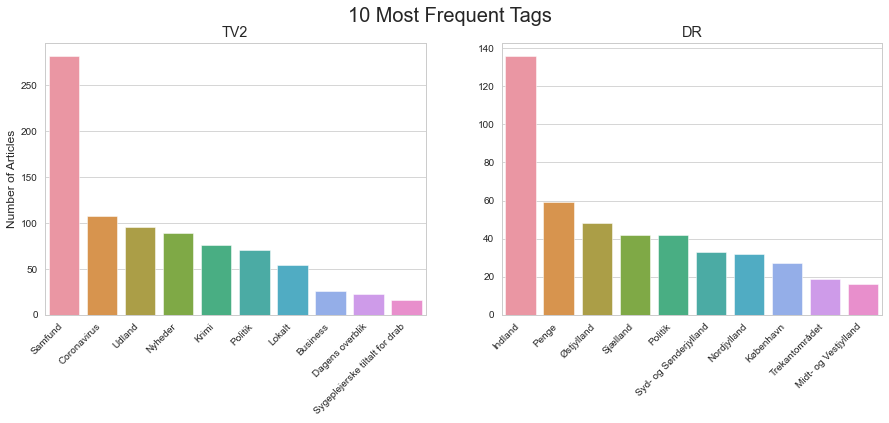

In [27]:
# Plotting count of tags
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))

ax[0] = sns.barplot(x = tv2_tags["tags"][0:10], y = tv2_tags["count"], orient ="v", ax = ax[0])
ax[1] = sns.barplot(x = dr_tags["tags"][0:10], y = dr_tags["count"], orient ="v", ax = ax[1])

_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')



_ = plt.suptitle("10 Most Frequent Tags", size=20)
_ = ax[0].set_title("TV2")
_ = ax[1].set_title("DR")
_ = ax[0].set_ylabel("Number of Articles")
_ = ax[1].set_ylabel("")

_ = ax[0].set(xlabel=None)
_ = ax[1].set(xlabel=None)
plt.savefig("tags.pdf", dpi=1200)

#### 3: Plotting google searches for sygeplej* on DR

In [29]:
dr_google_search_results

,search_results,month
0,2220,jan. 2012
1,1450,feb. 2012
2,1360,mar. 2012
3,1310,apr. 2012
4,1700,maj 2012
...,...,...
123,1160,apr. 2022
124,10600,maj 2022
125,22,jun. 2022
126,423,jul. 2022


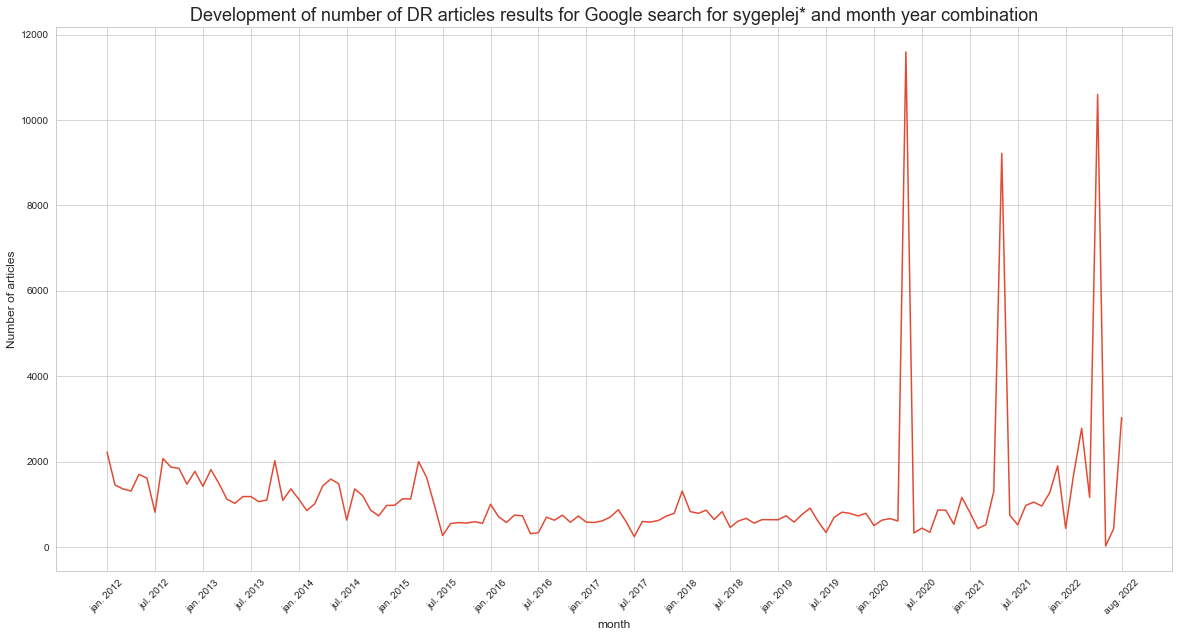

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20,10))

sns.lineplot(x = 'month', y = 'search_results', data = dr_google_search_results)

_ = plt.title ("Development of number of DR articles results for Google search for sygeplej* and month year combination", fontsize = 18)
_ = plt.ylabel("Number of articles")
_ = plt.xticks([0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 127])
_ = plt.xticks(rotation=45)


plt.savefig("DR_sygeplej_searches.pdf", dpi=1200)
plt.show()

In [31]:
dr_google_search_results = dr_google_search_results.sort_values('search_results', ascending = False)
dr_google_search_results.head(5)

,search_results,month
100,11600,maj 2020
124,10600,maj 2022
112,9220,maj 2021
127,3030,aug. 2022
122,2780,mar. 2022


In [32]:
with open('dr_months_most_searches_sygeplej.tex','w') as tf:
    tf.write(dr_google_search_results.head(5).to_latex(index=False))
with open('dr_months_least_searches_sygeplej.tex','w') as tf:
    tf.write(dr_google_search_results.tail(5).to_latex(index=False))

### Preparing documents

#### 1: Removing unnecessary characters

In [33]:
def analysis_cleaner(document):
    document = re.sub(r'[^\w\s]', '', document) #Remove non-alphanumeric characters
    document = re.sub(r'[^\D+]', '', document) #Remove non-numberic characters
    document = document.replace(r'\W', ' ')\
                .replace('  ', ' ')
    return document

In [34]:
dr_analysis = dr_sygeplej2x.copy()
tv2_analysis = tv2_sygeplej2x.copy()
ft_analysis = ft_sygeplej2x.copy()

dr_analysis["content_cleaned"] = dr_analysis["content"].apply(analysis_cleaner)
tv2_analysis["content_cleaned"] = tv2_analysis["content"].apply(analysis_cleaner)
ft_analysis["content_cleaned"] = ft_analysis["content"].apply(analysis_cleaner)

#### 3: Add preprocess column

Define function:

In [35]:
def pre_process(document):
    stemmer = SnowballStemmer("danish")
    danish_stopwords=stopwords.words("danish")
    
    document = nltk.tokenize.word_tokenize(document) # tokenize
    document = [word for word in document if not word in danish_stopwords] # delete stopwords
    document = [stemmer.stem(word) for word in document] # all stemmed words in a list
    document =' '.join(document) # joining stemmed words
    return document

Run function on datasets to create a conten_cleaned column:

In [59]:
dr_analysis["content_prepr"] = dr_analysis["content_cleaned"].apply(pre_process)
tv2_analysis["content_prepr"] = tv2_analysis["content_cleaned"].apply(pre_process)
ft_analysis["content_prepr"] = ft_analysis["content_cleaned"].apply(pre_process)

In [60]:
# GOOGLE MAY 2020, 2021, 2021

def top_words_month(df, year, month):
    df_year=df[df['date'].dt.year == year]
    df_month=df[df['date'].dt.month == month]
    df_month_bow=BoW_relevant(df_month)
    return df_month_bow

In [61]:
dr_analysis_May20 = top_words_month(dr_analysis, 2022, 5)

UnboundLocalError: local variable 'matrix_sum' referenced before assignment

In [41]:
dr_analysis_

,titles,sub_header,h2,content,author,tag,date,link,source,content_cleaned,content_prepr
0,danske sygeplejersker får job i norge,"krise, fyringer og ansættelsesstop får sygeple...",markant flere,"antallet af danske sygeplejersker, der har fåe...",ritzau/,Penge,2012-01-19 13:27:00+00:00,https://www.dr.dk/nyheder/penge/danske-sygeple...,DR,antallet af danske sygeplejersker der har fået...,antal dansk sygeplejersk fået autorisation nor...
1,næsten ingen ledige sygeplejersker,trods fyringsrunder i både 2010 og 2011 er arb...,NaN,trods fyringsrunder på sygehusene i både 2010 ...,henny mortensen,Sjælland,2012-01-28 07:42:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR,trods fyringsrunder på sygehusene i både og og...,trod fyringsrund sygehus båd nedlæg sygehus fa...
5,regionsformand: jeg har ikke noget at undskylde,"steen bach nielsen forstår ikke, at sygeplejer...",NaN,der er ikke noget at undskylde eller beklage.....,jørgen hansen,Sjælland,2012-01-24 15:39:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR,der er ikke noget at undskylde eller beklage f...,undskyld beklag formand region sjælland steen ...
14,sygeplejersker vil skære i nattevagter,risiko for at natarbejde er kræftfremkaldende ...,færre nattevagter fast døgnrytme er vigtig,"dansk sygeplejeråd, der repræsenterer landets ...",ritzau,Indland,2012-02-21 10:48:00+00:00,https://www.dr.dk/nyheder/indland/sygeplejersk...,DR,dansk sygeplejeråd der repræsenterer landets o...,dansk sygeplejeråd repræsent land omkring syge...
15,udenlandske sygeplejersker er taget hjem,det er slut med sygeplejerudtryk på gebrokkent...,NaN,det er slut med sygeplejerudtryk på gebrokkent...,mikkel from nielsen,Nordjylland,2012-02-27 15:26:00+00:00,https://www.dr.dk/nyheder/regionale/nordjyllan...,DR,det er slut med sygeplejerudtryk på gebrokkent...,slut sygeplejerudtryk gebrokkent dansk nordjys...
...,...,...,...,...,...,...,...,...,...,...,...
1495,læger og sygeplejersker siger stop: 'kan ikke ...,"ifølge ansatte på holbæk sygehus, så er forhol...",besøg fra arbejdstilsynet klare krav,"det er ikke kun sygeplejersker, der flygter fr...",trine warrer juul,Sjælland,2021-12-06 04:55:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR,det er ikke kun sygeplejersker der flygter fra...,kun sygeplejersk flygt region sjælland sygehus...
1496,detektor: talsperson erkender - har ikke tal p...,talsperson for opsigelser blandt sygeplejerske...,debatindlæg som dokumenation sundhedsøkonom: '...,"- patienter ligger på gangene og dør, fordi de...",august stenbroen,Detektor,2021-12-22 19:39:00+00:00,https://www.dr.dk/nyheder/detektor/detektor-ta...,DR,patienter ligger på gangene og dør fordi de i...,patient lig gang dør fordi tils sagd luca pris...
1497,flere sygeplejersker skifter til det private: ...,der skal gøres noget ved løn og vilkår i det o...,fik hjertebanken sygeplejerskerne siger fra ’i...,"højere løn og bedre arbejdstider. det var det,...",allan nisgaard,Indland,2021-12-29 04:46:00+00:00,https://www.dr.dk/nyheder/indland/flere-sygepl...,DR,højere løn og bedre arbejdstider det var det s...,høj løn bedr arbejdstid fik sygeplejerskevikar...
1498,nu skal sygeplejersker og læger fra hospitaler...,i både region midtjylland og region syddanmark...,frygter længere ventelister ansætter mange,meldingen fra sundhedsmyndighederne har været ...,emil eller,Indland,2021-12-15 04:50:00+00:00,https://www.dr.dk/nyheder/indland/nu-skal-syge...,DR,meldingen fra sundhedsmyndighederne har været ...,melding sundhedsmyndighed helt klar rigt fart ...


#### 4: Add a column with words within n words of sygeplejsk* in documents

Defining a function that returns the sorrounding n words for a given word:

In [37]:
def extract_surround_words_BetterRead(text, keyword, n):
    '''
    text : input text
    keyword : the search keyword we are looking
    n : number of words around the keyword
    '''
    surround_words=[]
    #extracting all the words from text
    words = re.findall(r'\w+', text)
    
    #iterate through all the words
    for index, word in enumerate(words):

        #check if search keyword matches
        if keyword in word:
            #fetch left side words
            left_side_words = words[index-n : index]
            
            #fetch right side words
            right_side_words = words[index+1 : index + n + 1]
            
            surround_words.append(left_side_words + keyword)
            surround_words.append(right_side_words)
    return surround_words

Defining a function that creates a new column with extract_surround_words function for our three datasets:

In [38]:
def find_relevant_BetterRead(df, word, n):
    r=[]
    for row in df["content_cleaned"]:
        temp= extract_surround_words_BetterRead(row, word, n)
        temp_list=[]
        for i in temp:
            stems=' '.join(i)
            temp_list.append(stems)
            s=" ".join(temp_list)
        r.append(s)
    df['relevant_text']=r
    return df

In [39]:
dr_analysis

,titles,sub_header,h2,content,author,tag,date,link,source,content_cleaned,content_prepr
0,danske sygeplejersker får job i norge,"krise, fyringer og ansættelsesstop får sygeple...",markant flere,"antallet af danske sygeplejersker, der har fåe...",ritzau/,Penge,2012-01-19 13:27:00+00:00,https://www.dr.dk/nyheder/penge/danske-sygeple...,DR,antallet af danske sygeplejersker der har fået...,antal dansk sygeplejersk fået autorisation nor...
1,næsten ingen ledige sygeplejersker,trods fyringsrunder i både 2010 og 2011 er arb...,NaN,trods fyringsrunder på sygehusene i både 2010 ...,henny mortensen,Sjælland,2012-01-28 07:42:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR,trods fyringsrunder på sygehusene i både og og...,trod fyringsrund sygehus båd nedlæg sygehus fa...
5,regionsformand: jeg har ikke noget at undskylde,"steen bach nielsen forstår ikke, at sygeplejer...",NaN,der er ikke noget at undskylde eller beklage.....,jørgen hansen,Sjælland,2012-01-24 15:39:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR,der er ikke noget at undskylde eller beklage f...,undskyld beklag formand region sjælland steen ...
14,sygeplejersker vil skære i nattevagter,risiko for at natarbejde er kræftfremkaldende ...,færre nattevagter fast døgnrytme er vigtig,"dansk sygeplejeråd, der repræsenterer landets ...",ritzau,Indland,2012-02-21 10:48:00+00:00,https://www.dr.dk/nyheder/indland/sygeplejersk...,DR,dansk sygeplejeråd der repræsenterer landets o...,dansk sygeplejeråd repræsent land omkring syge...
15,udenlandske sygeplejersker er taget hjem,det er slut med sygeplejerudtryk på gebrokkent...,NaN,det er slut med sygeplejerudtryk på gebrokkent...,mikkel from nielsen,Nordjylland,2012-02-27 15:26:00+00:00,https://www.dr.dk/nyheder/regionale/nordjyllan...,DR,det er slut med sygeplejerudtryk på gebrokkent...,slut sygeplejerudtryk gebrokkent dansk nordjys...
...,...,...,...,...,...,...,...,...,...,...,...
1495,læger og sygeplejersker siger stop: 'kan ikke ...,"ifølge ansatte på holbæk sygehus, så er forhol...",besøg fra arbejdstilsynet klare krav,"det er ikke kun sygeplejersker, der flygter fr...",trine warrer juul,Sjælland,2021-12-06 04:55:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR,det er ikke kun sygeplejersker der flygter fra...,kun sygeplejersk flygt region sjælland sygehus...
1496,detektor: talsperson erkender - har ikke tal p...,talsperson for opsigelser blandt sygeplejerske...,debatindlæg som dokumenation sundhedsøkonom: '...,"- patienter ligger på gangene og dør, fordi de...",august stenbroen,Detektor,2021-12-22 19:39:00+00:00,https://www.dr.dk/nyheder/detektor/detektor-ta...,DR,patienter ligger på gangene og dør fordi de i...,patient lig gang dør fordi tils sagd luca pris...
1497,flere sygeplejersker skifter til det private: ...,der skal gøres noget ved løn og vilkår i det o...,fik hjertebanken sygeplejerskerne siger fra ’i...,"højere løn og bedre arbejdstider. det var det,...",allan nisgaard,Indland,2021-12-29 04:46:00+00:00,https://www.dr.dk/nyheder/indland/flere-sygepl...,DR,højere løn og bedre arbejdstider det var det s...,høj løn bedr arbejdstid fik sygeplejerskevikar...
1498,nu skal sygeplejersker og læger fra hospitaler...,i både region midtjylland og region syddanmark...,frygter længere ventelister ansætter mange,meldingen fra sundhedsmyndighederne har været ...,emil eller,Indland,2021-12-15 04:50:00+00:00,https://www.dr.dk/nyheder/indland/nu-skal-syge...,DR,meldingen fra sundhedsmyndighederne har været ...,melding sundhedsmyndighed helt klar rigt fart ...


Creating a new column with the three words before and after sygeplejersk is mentioned for each document

In [40]:
dr_analysis=find_relevant(dr_analysis, "sygeplejersk", 3)
tv2_analysis=find_relevant(tv2_analysis, "sygeplejersk", 3)
ft_analysis=find_relevant(ft_analysis, "sygeplejersk", 3)

NameError: name 'find_relevant' is not defined

### Word frequency analysis

#### 1: Defining function to create a Bag of Words summed table for entire source

In [44]:
def BoW(df): 
    count = CountVectorizer()
    df_array = df["content_prepr"]
    bag = count.fit_transform(df_array)
    
    count_array = bag.toarray() #Make the bag to an array
    matrix = pd.DataFrame(data=count_array,columns = count.get_feature_names())
    matrix_sum = matrix.sum().transpose()
    matrix_sum.sort_values(ascending = False, inplace = True)
    return matrix_sum

In [45]:
def BoW_relevant(df): 
    try :
        count = CountVectorizer()
        df_array = df['relevant']
        bag = count.fit_transform(df_array)

        count_array = bag.toarray()#Make the bag to an array
        matrix = pd.DataFrame(data=count_array,columns = count.get_feature_names())
        matrix_sum = matrix.sum().transpose()
        matrix_sum.sort_values(ascending = False, inplace = True)
    except:
        pass
    return matrix_sum

# Overvej om der skal være et BoW exploring afsnit eller om vi skal gå direkte til wordcloud/sentiment

#### 2: Wordcount with relevant words

In [58]:
dr_bow_rel= BoW_relevant(dr_analysis)
tv2_bow_rel = BoW_relevant(tv2_analysis)
ft_bow_rel= BoW_relevant(ft_analysis)

UnboundLocalError: local variable 'matrix_sum' referenced before assignment

Export wordcount list of relevant words to latex:

In [ ]:
red_circle=np.array(Image.open( "red_circle.png"))

In [ ]:
with open('dr_bow_rel.tex','w') as tf:
    tf.write(dr_bow_rel.head(100).to_latex(index=False))
with open('tv2_bow_rel.tex','w') as tf:
    tf.write(tv2_bow_rel.head(100).to_latex(index=False))
with open('ft_bow_rel.tex','w') as tf:
    tf.write(ft_bow_rel.head(100).to_latex(index=False))

#### 3: Creating a wordcloud of relevant words for each source

Importing background :

In [ ]:
red_circle=np.array(Image.open( "red_circle.png"))

Plotting the wordclouds

#### 3: Most used words each year for each source

Defining function to get a bow for a year:

In [55]:
def top_words(df, year):
    df_year=df[df['date'].dt.year == year]
    df_year_bow=BoW_relevant(df_year)
    return df_year_bow

Defining function to get topwords for all years for a given df:

In [54]:
def top_words_table(df, num_top_words, end_year):
    top_words_list=[]
    year_list=[]
    for year in range(2012, end_year+1,1):
        top=top_words(df, year)
        top=top[:num_top_words+1]
        top_words_list.append(top.index)
        year_list.append(year)
    top_words_df=pd.DataFrame([i for i in top_words_list], year_list).transpose()
    
        
    return top_words_df

Creating tables of top 10 words used each year for each datafram:

In [53]:
tv2_top_words=top_words_table(tv2_analysis, 10, 2022)
with open('tv2_topwords.tex','w') as tf:
    tf.write(tv2_top_words.to_latex(index=False))

ft_top_words=top_words_table(ft_analysis, 10, 2022)
with open('ft_topwords.tex','w') as tf:
    tf.write(ft_top_words.to_latex(index=False))

dr_top_words=top_words_table(dr_analysis, 10, 2021)
with open('dr_topwords.tex','w') as tf:
    tf.write(dr_top_words.to_latex(index=False))

NameError: name 'top_words_table' is not defined

In [52]:
def get_title_samples(df_analysis, word, year):
    df_year = df_analysis[df_analysis['date'].dt.year == year]
    df_year = df_year[df_year['relevant'].str.contains(f"{word}")]
    return df_year

#### 1: Defining sentiment analysis function and appending sentiment column to df

In [51]:
def sentida_values(df): 
    sentida_preds = []

    for i, row in tqdm.tqdm(df.iterrows()):
        score = Sentida().sentida(row.content_cleaned, output = 'mean', normal = True)
        sentida_preds.append(score)
    
    return sentida_preds

In [50]:
def sentiment_column(df):
    sentida_preds = sentida_values(df)
    df['sentiment'] = sentida_preds # create new column: sentime

#### 2: Finding 100 words near words that contain 'sygeplejersk' to be used for FT

In [48]:
def extract_surround_words(text, keyword, n):
    '''
    text : input text
    keyword : the search keyword we are looking
    n : number of words around the keyword
    '''
    surround_words=[]
    #extracting all the words from text
    words = words = re.findall(r'\w+', text)
    
    #iterate through all the words
    for index, word in enumerate(words):

        #check if search keyword matches
        if keyword in word:
            #fetch left side words
            left_side_words = words[index-n : index]
            
            #fetch right side words
            right_side_words = words[index+1 : index + n + 1]
            
            surround_words.append(left_side_words)
            surround_words.append(right_side_words)
    return surround_words

In [49]:
def find_relevant_sen(df, word, n):
    r=[]
    for row in df["content_cleaned"]:
        temp=extract_surround_words(row, word, n)
        temp_list=[]
        for i in temp:
            stems = ' '.join(i)
            temp_list.append(stems)
        s = " ".join(temp_list)
        r.append(s)
        s = ""
    df['relevant_sen']=r
    return df

In [ ]:
sentiment_column(dr_analysis) # dr: create sentiment values and append to new sentiment column

In [ ]:
sentiment_column(tv2_analysis) # tv2: create sentiment values and append to new sentiment column

In [ ]:
ft_analysis = find_relevant_sen(ft_analysis, "sygeplej", 100) # searching for words close to 'sygeplej'

In [ ]:
sentida_preds_ft = []

for i, row in tqdm.tqdm(ft_analysis.iterrows()):
    score = Sentida().sentida(row.relevant_sen, output = 'mean', normal = True)
    sentida_preds_ft.append(score) # create sentiment values
    
ft_analysis['sentiment'] = sentida_preds_ft # # ft: append to new sentiment column

In [ ]:
ft_analysis['sentiment'] = sentida_preds_ft # create new column in ft_analysis df: sentiment 